# Эксперименты с временным рядом стоимости алюминия с моделью Catboost

In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [13]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from darts import TimeSeries
from darts.metrics import mape
from darts.models import CatBoostModel
from darts.dataprocessing.transformers import Scaler

from datetime import timedelta
from copy import deepcopy

import optuna
from functools import partial

In [14]:
import random
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    
set_seed()

# Данные

In [15]:
FORECAST_LEN = 4 # forecast horizon
OUT_OF_TIME_DIM = 20 # out-of-time dimension

In [16]:
df = pd.read_csv('prepared_dataset_al.csv', parse_dates=[0], dtype='float32')
print('Shape:', df.shape)

Shape: (333, 23)


In [17]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем ковариаты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# out-of-time выборка будет использована лишь в самом конце

In [18]:
import datetime

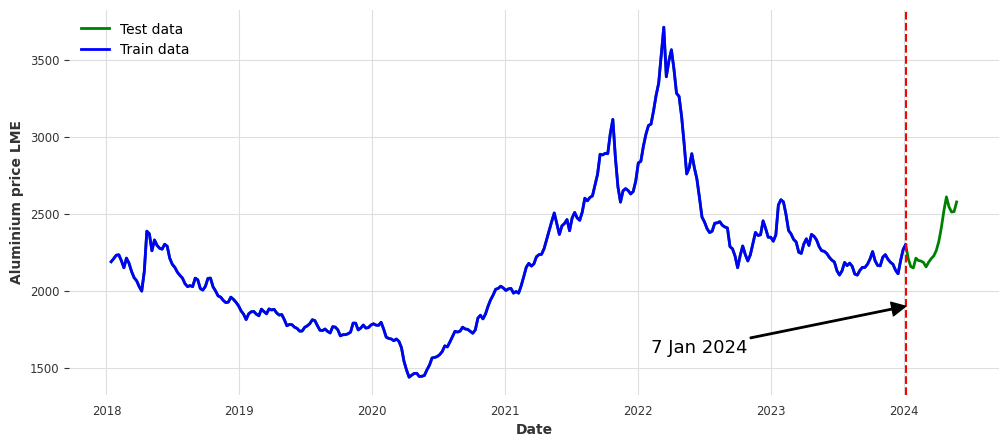

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
data_ts.plot(label="Test data", color='g')
ts.plot(label="Train data", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('7 Jan 2024', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
#plt.savefig('preview.png', dpi=400, format='png')

### Cross-validation

Так как backtest не работает, пропишем ручную версию  
В ручной версии подразумевается обучение модели с нуля на каждом шаге

In [31]:
def manual_backtest(model_settings,
                    ts,
                    past_covariates,
                    forecast_horizont=FORECAST_LEN, 
                    start_test=180,
                    step = 30,
                    save_curves=False,
                    rolling_window=False,
                    window_size=None,
                    verbose=True
                   ):
    '''
    Функция аналогична встроенной функции backtest
    '''
    shift = max(model_settings["lags"], model_settings["lags_past_covariates"])
    metrics = list() # Список для метрик
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        if verbose is True:
            print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test - shift : start_test + int(forecast_horizont)]
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test - shift : start_test + int(forecast_horizont)]
            
            model = CatBoostModel(
                **model_settings,
                output_chunk_length=forecast_horizont,
                eval_metric = 'MAPE',
                early_stopping_rounds = 15,
                task_type = "GPU",
                #thread_count = 8,
                random_state=42
            )
            
            model.fit(series=cur_train,
                      val_series=cur_test,
                      past_covariates=past_cov_train,
                      val_past_covariates=past_cov_test)
            
            prediction = model.predict(int(forecast_horizont),
                                       series=cur_train,
                                       past_covariates=past_cov_train)
        # Если экзогенных признаков нет  
        else:            
            model = CatBoostModel(
                **model_settings,
                output_chunk_length=forecast_horizont,
                eval_metric = 'MAPE',
                early_stopping_rounds = 15,
                task_type = "GPU",
                #thread_count = 8,
                random_state=42
            )
            
            model.fit(series=cur_train,
                      val_series=cur_test)
            
            prediction = model.predict(int(forecast_horizont),
                                       series=cur_train)
            
        # Вычисляем метрику и добавляем в список   
        metric = mape(cur_test, prediction, intersect=True)
        metrics.append(metric)
        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=prediction
        k+=1
        
        start_test+=step
        if rolling_window:
            start_train+=step
        if start_test + int(forecast_horizont) > len(ts):
            break
            
    if save_curves==True:
        return metrics, prediction_curves
    else:
        return metrics

### Hyperparameter optimization (optuna)

In [27]:
class LoggingCallback:
    def __init__(self, interval=1):
        self.interval = interval

    def __call__(self, study, trial):
        if trial.number % self.interval == 0:
            print(f"Trial number: {trial.number}, Trial value: {trial.value:.2f}, Trial params: {trial.params}", end='\n\n')
            print(f"Best trial: {study.best_trial.number}, Best value: {study.best_value:.2f}, Best params: {study.best_trial.params}", end='\n\n')

In [22]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [57]:
def objective(trial, ts, past_cov, forecast_len = FORECAST_LEN):
    
    settings = {
        "lags" : trial.suggest_int("lags", 1, 50),
        "lags_past_covariates" : trial.suggest_int("lags_past_covariates", 1, 50),
        "iterations" : trial.suggest_int("iterations", low=50, high=500, step=50),
        #"learning_rate" : trial.suggest_float("learning_rate", 1e-6, 0.1, log=True),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", low=1.0, high=9.0, step=0.4),
        "depth" : trial.suggest_int("depth", 3, 8),
#         "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 1, 200),
#         "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

#     if settings["bootstrap_type"] == "Bayesian":
#         settings["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
     
#     elif settings["bootstrap_type"] == "Bernoulli":
#         settings["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [52, 104])

    # Evaluate how good it is on the cross_validation for ts
    metrics = manual_backtest(model_settings=settings,
                              ts=ts,
                              past_covariates=past_cov,
                              **settings_for_backtest)
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def opt(ts, past_cov, iterations):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_function, n_trials=iterations, callbacks=[LoggingCallback()])
    print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')
    return study

In [24]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    return best_params, settings_for_backtest

In [51]:
def build_and_fit_model(model_settings,
                        backtest_settings,
                        ts,
                        past_cov,
                        forecast_len=FORECAST_LEN):
    model = CatBoostModel(
        **model_settings,
        output_chunk_length=forecast_len,
        eval_metric = "MAPE",
        early_stopping_rounds = 15,
        task_type = "CPU",
        #devices='1',
        thread_count = 16,
        random_state=42
    )

    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    
    if backtest_settings["rolling_window"]==True:
        ts_train, ts_valid = ts[- backtest_settings["window_size"] - int(forecast_len) : - int(forecast_len)], ts[- int(forecast_len) - shift : ]
        past_cov_train, past_cov_valid = past_cov[- backtest_settings["window_size"] - int(forecast_len) : - int(forecast_len)], past_cov[- int(forecast_len) - shift : ]
    else:
        ts_train, ts_valid = ts[ : - int(forecast_len)], ts[- int(forecast_len) - shift : ]
        past_cov_train, past_cov_valid = past_cov[ : - int(forecast_len)], past_cov[- int(forecast_len) - shift : ]
        
    model.fit(series=ts_train,
              past_covariates=past_cov_train,
              val_series=ts_valid,
              val_past_covariates=past_cov_valid,
              verbose=False
             )
    
    return model

def evaluation(model_settings,
               backtest_settings,
               data_ts,
               data_past_cov,
               forecast_len=FORECAST_LEN,
               out_of_time_dim=OUT_OF_TIME_DIM,
               refit = None
              ):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    data_ts - датасет временного ряда
    data_past_cov - датасет ковариант
    model_settings и backtest_settings - настройки модели,
    forecast_len - длина прогноза,
    out_of_time_dim - размер выборки out-of-time
    
    Scaler-ов нет, так как в градиентном бустинге не был использованы
    '''
    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model_settings["lags"], model_settings["lags_past_covariates"])
    price = data_ts.copy()
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    if refit == True:
        while True:
            tmp_ts = data_ts[:-out_of_time_dim+start_point]
            tmp_past_cov = data_past_cov[:-out_of_time_dim+start_point]
            print("Building model")
            model = build_and_fit_model(model_settings=model_settings,
                                        backtest_settings=backtest_settings,
                                        ts=tmp_ts,
                                        past_cov=tmp_past_cov)

            cur_test_input = out_of_time_ts[start_point : start_point + shift]
            past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
            prediction = model.predict(int(forecast_len),
                                       series=cur_test_input, 
                                       past_covariates=past_cov_test_input)
            metric = mape(prediction, price)
            metrics.append(metric)
            start_point+=step
            prediction_curves[start_point]=prediction
            if start_point + shift + int(forecast_len) > len(out_of_time_ts):
                break
        print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
        return prediction_curves, metrics
    
    elif refit == False:
        tmp_ts = data_ts[:-out_of_time_dim]
        tmp_past_cov = data_past_cov[:-out_of_time_dim]
        print("Building model")
        model = build_and_fit_model(model_settings=model_settings,
                                    backtest_settings=backtest_settings,
                                    ts=tmp_ts,
                                    past_cov=tmp_past_cov)
        while True:
            cur_test_input = out_of_time_ts[start_point : start_point + shift]
            past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
            prediction = model.predict(int(forecast_len),
                                       series=cur_test_input,
                                       past_covariates=past_cov_test_input)
            metric = mape(prediction, price)
            metrics.append(metric)
            start_point+=step
            prediction_curves[start_point]=prediction
            if start_point + shift + int(forecast_len) > len(out_of_time_ts):
                break
        print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
        return prediction_curves, metrics
    
    else:
        print("Установите значение параметра refit!")
        pass

## Building model

In [58]:
study = opt(ts=ts, past_cov=past_cov, iterations=20)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Trial number: 0, Trial value: 4.47, Trial params: {'lags': 44, 'lags_past_covariates': 46, 'iterations': 300, 'l2_leaf_reg': 3.4000000000000004, 'depth': 4, 'min_data_in_leaf': 24, 'rolling_window': False}

Best trial: 0, Best value: 4.47, Best params: {'lags': 44, 'lags_past_covariates': 46, 'iterations': 300, 'l2_leaf_reg': 3.4000000000000004, 'depth': 4, 'min_data_in_leaf': 24, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Trial number: 1, Trial value: 7.40, Trial params: {'lags': 41, 'lags_past_covariates': 31, 'iterations': 200, 'l2_leaf_reg': 8.2, 'depth': 5, 'min_data_in_leaf': 126, 'rolling_window': True, 'window_size': 104}

Best trial: 0, Best value: 4.47, Best params: {'lags': 44, 'lags_past_covariates': 46, 'iterations': 300, 'l2_leaf_reg': 3.4000000000000004, 'depth': 4, 'min_data_in_leaf': 24, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Trial number: 2, Trial value: 5.36, Tria

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Trial number: 19, Trial value: 3.61, Trial params: {'lags': 1, 'lags_past_covariates': 15, 'iterations': 450, 'l2_leaf_reg': 9.0, 'depth': 4, 'min_data_in_leaf': 111, 'rolling_window': False}

Best trial: 12, Best value: 3.25, Best params: {'lags': 31, 'lags_past_covariates': 13, 'iterations': 400, 'l2_leaf_reg': 2.6, 'depth': 3, 'min_data_in_leaf': 133, 'rolling_window': False}

Number of finished trials: 20

Best value: 3.2508891820808272, Best params: {'lags': 31, 'lags_past_covariates': 13, 'iterations': 400, 'l2_leaf_reg': 2.6, 'depth': 3, 'min_data_in_leaf': 133, 'rolling_window': False}



In [59]:
best_params = study.best_trial.params
model_settings, backtest_settings = setup_params(best_params)

In [68]:
model_settings

{'lags': 31,
 'lags_past_covariates': 13,
 'iterations': 400,
 'l2_leaf_reg': 2.6,
 'depth': 3,
 'min_data_in_leaf': 133}

In [69]:
backtest_settings

{'rolling_window': False}

### Backtest with refit on each step

In [70]:
bt_metrics, pred_ts = manual_backtest(model_settings=best_params,
                                      ts=ts,
                                      past_covariates=past_cov,
                                      save_curves=True,
                                      **backtest_settings)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5


In [71]:
print("Backtest MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_metrics), np.std(bt_metrics)))

Backtest MAPE: 3.25 +- 2.88


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


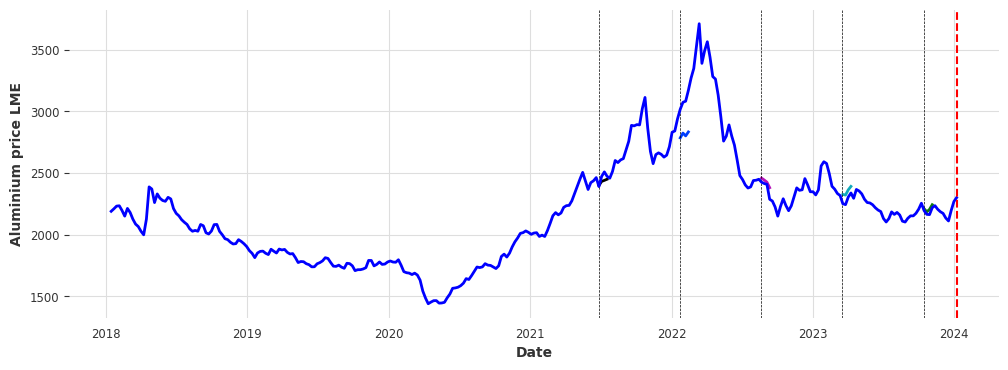

In [72]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1),
               color='black',
               linestyle='--',
               linewidth=0.5)
ts.plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
plt.savefig('Backtest_catboost.png', dpi=400, format='png')

### Fit and evaluate without refitting

In [73]:
prediction_curves_without_refit, \
metrics_without_refit = evaluation(model_settings=best_params,
                                           backtest_settings=backtest_settings,
                                           data_ts=data_ts,
                                           data_past_cov=data_past_cov,
                                           forecast_len=FORECAST_LEN,
                                           out_of_time_dim=OUT_OF_TIME_DIM,
                                           refit = False)

Building model
MAPE: 5.34 +- 4.89


<Axes: xlabel='date'>

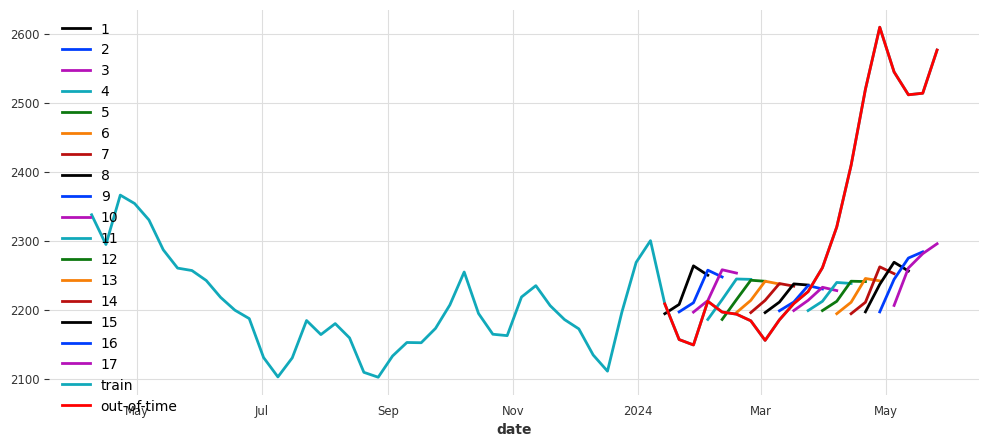

In [74]:
plt.figure(figsize=(12,5))
for key, value in prediction_curves_without_refit.items():
    value.plot(label=key)
data_ts[-3*OUT_OF_TIME_DIM:].plot(label='train')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time', color='r')

### Fit and evaluate with refitting

In [75]:
prediction_curves_with_refit, \
metrics_with_refit = evaluation(model_settings=best_params,
                                           backtest_settings=backtest_settings,
                                           data_ts=data_ts,
                                           data_past_cov=data_past_cov,
                                           forecast_len=FORECAST_LEN,
                                           out_of_time_dim=OUT_OF_TIME_DIM,
                                           refit = True)

Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
Building model
MAPE: 5.37 +- 4.93


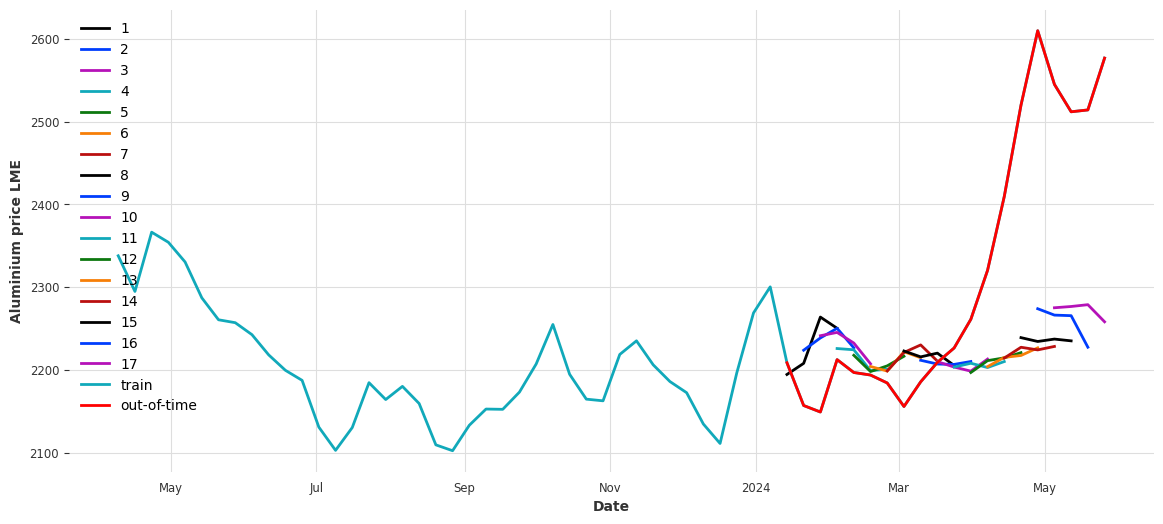

In [76]:
fig, ax = plt.subplots(figsize=(14, 6))
for key, value in prediction_curves_with_refit.items():
    value.plot(label=key)
data_ts[-3*OUT_OF_TIME_DIM:].plot(label='train')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time', color='r')
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
plt.savefig('Out_of_time_test_catboost.png', dpi=400, format='png')